In [1]:
tissue = "nose"
normalize = True

# Dask params
n_workers = 4
dask_chunk_size = 80_000
threads_per_worker = None
dashboard_port = 8786

In [2]:
from dask.distributed import Client, LocalCluster

if n_workers is None:
    n_workers = cpu_count() // threads_per_worker
cluster = LocalCluster(
    n_workers=n_workers,
    threads_per_worker=threads_per_worker,
    dashboard_address=f":{dashboard_port}",
)
print(f"{n_workers=}, {threads_per_worker=}")
client = Client(cluster)

client

n_workers=4, threads_per_worker=None


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8786/status,
Dashboard: http://127.0.0.1:8786/status,Workers: 4
Total threads: 64,Total memory: 246.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39743,Workers: 4
Dashboard: http://127.0.0.1:8786/status,Total threads: 64
Started: Just now,Total memory: 246.55 GiB
Comm: tcp://127.0.0.1:43497,Total threads: 16
Dashboard: http://127.0.0.1:39305/status,Memory: 61.64 GiB
Nanny: tcp://127.0.0.1:44217,


In [3]:
%%time
import h5py
import anndata as ad

path = f'data/{tissue}.h5ad'

with h5py.File(path, "r") as f:
    adata = ad.AnnData(
        obs=ad.io.read_elem(f["obs"]),
        var=ad.io.read_elem(f["var"]),
    )
    adata.X = ad.experimental.read_elem_as_dask(
        f["X"], chunks=(dask_chunk_size, adata.shape[1])
    )
adata

CPU times: user 790 ms, sys: 175 ms, total: 965 ms
Wall time: 944 ms


AnnData object with n_obs × n_vars = 313887 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [4]:
import scanpy as sc
from scanpy.preprocessing._utils import _get_mean_var

In [5]:
%%time
if normalize:
    sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 11.3 ms, sys: 10 μs, total: 11.3 ms
Wall time: 11 ms


In [6]:
%%time
mv0, mv1 = _get_mean_var(adata.X)
mv1

CPU times: user 25.1 ms, sys: 972 μs, total: 26.1 ms
Wall time: 25.8 ms


dask.array<mul, shape=(60530,), dtype=float64, chunksize=(60530,), chunktype=numpy.ndarray>

In [7]:
mv1.dask

HighLevelGraph with 18 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7bb3f4d9fec0>
 0. original-block-info-make_dask_chunk-c500796e32605946709afd6ccd048500
 1. block-info-make_dask_chunk-c500796e32605946709afd6ccd048500
 2. make_dask_chunk-c500796e32605946709afd6ccd048500
 3. sum_drop_keepdims-07e87ac5018017064e8db4335edf198f
 4. aggregate_sum-aggregate-9cf2bff6449223b06b0a2fad6eebd081
 5. truediv-b9f3fb2513ceb074b1f4e046c31d3bcd
 6. getitem-c273464adfb2a4808255282fae3ddf76
 7. axis_mul_or_truediv-3a889acf7a48e8a5768d59e1b57dacf8
 8. sum_drop_keepdims-bff4b8e48b3c9df8f6b5f5cac926aa43
 9. aggregate_sum-aggregate-7978fc5a54f30e106c863c40fdf4bef6
 10. truediv-4b21cb2d86eec73a9aa1884028aae91d
 11. pow-c27b860f77b62961c44f080a7ab63eb6
 12. elem_mul-2b3b2b07c30aa86c9e0da279853227b4
 13. sum_drop_keepdims-df75c54dda198506c89df5df9623cc41
 14. aggregate_sum-aggregate-952125b3edf49ac8ad32f92ffcfc5870
 15. truediv-332900bb3d1a65354cd5a04e2e7aea23
 16. sub-5bb304deb1094fa8eb471c3c2438283e
 17. mul-2b510cf7b263f8870c82f6b5f1c9a521

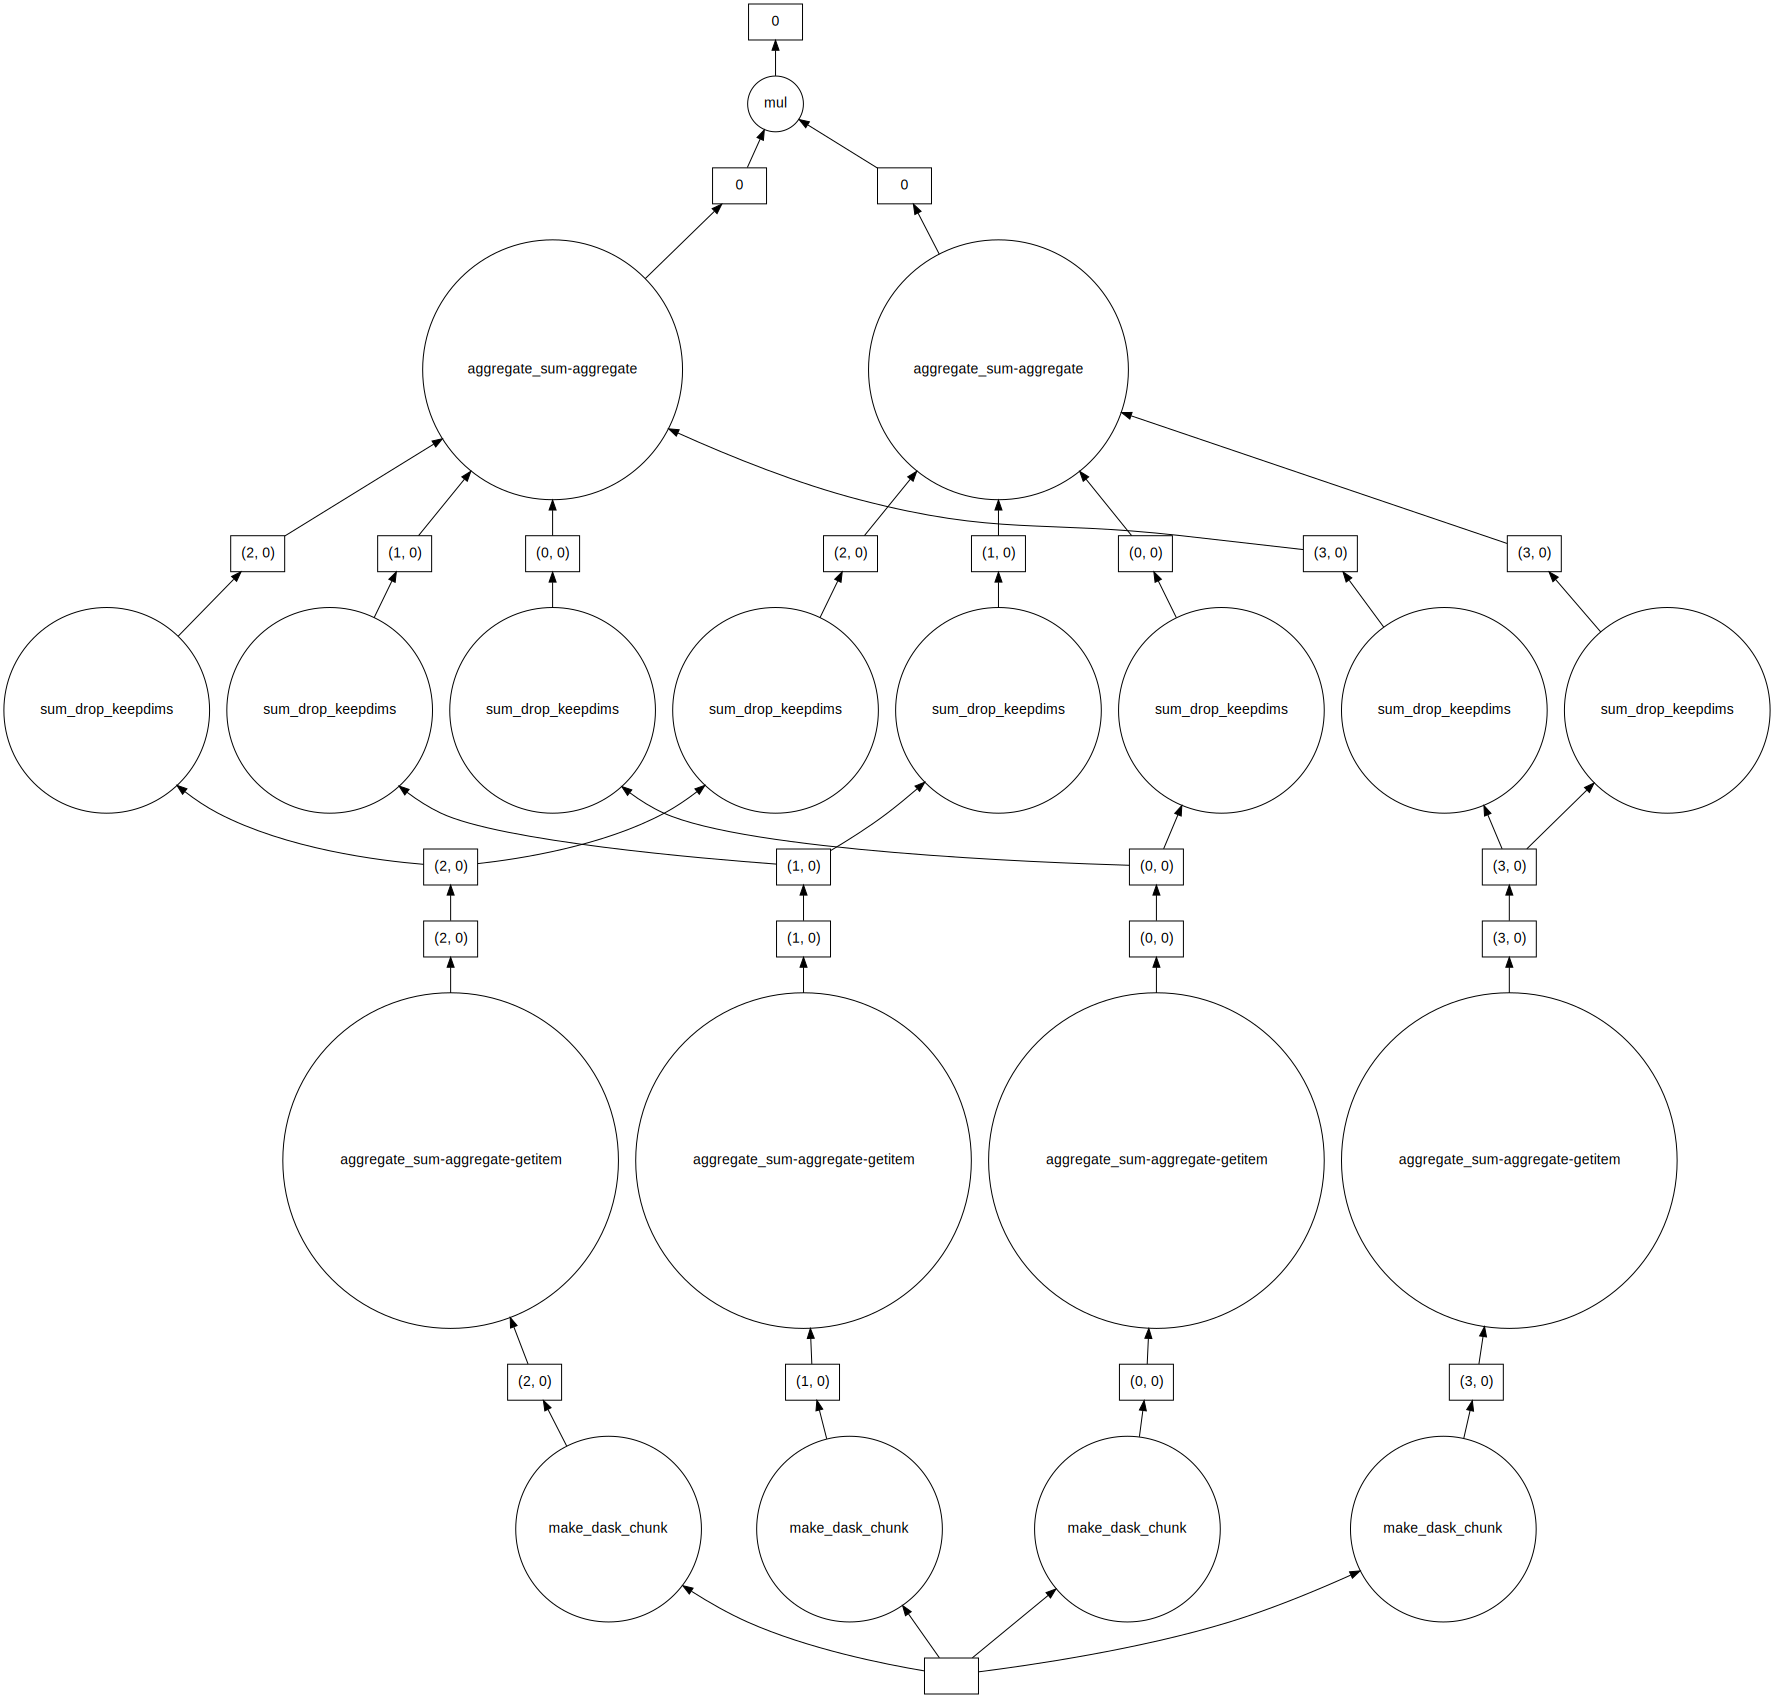

In [8]:
name = 'mean-var-norm' if normalize else 'mean-var'
name += f'-{tissue}-h5ad.opt.svg'
mv1.visualize(name, optimize_graph=True)

In [9]:
%%time
mv1c = mv1.compute()
mv1c

CPU times: user 1.91 s, sys: 136 ms, total: 2.05 s
Wall time: 20.4 s


array([9.70521045e+00, 1.59339051e-03, 2.07362090e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])